In [8]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from functions import *
from utils import *
from _polychrom import *

import time

def generate_polymer_chain(
    num_monomers: int, 
    num_polymers: int,
    num_observations: int, 
    save_folder: str, 
    # optional arguments 
    monomer_types: np.ndarray = None, # make sure that len(monomer_type_list) == num_monomers 
    interaction_matrix: np.ndarray = None, # make sure dim = monomer_types x monomer_types 
    ctcf_sites: list = [],
    ctcf_directions: list = None, # make sure len(dir) == len(sites)
    ctcf_stall_probs: list = None, 
    num_lef: int = None, 
    lef_load_prob: float = None , 
    extra_bond_pairs: list = [], # make sure it is nested 
    num_templates: int = 100
    ): 
    """ 
    Add documentation here
    """
    if save_folder[-1] != '/':
        save_folder += '/'
    
    # Initialize optional arguments 
    if monomer_types is None:
        monomer_types = np.zeros(num_monomers).astype(int)
    assert len(monomer_types) == num_monomers, "The length of monomer_types types should equal to num_monomers!"
    
    num_unique_monomer_type = len(np.unique(monomer_types))
    if interaction_matrix is None:
        interaction_matrix = np.zeros([num_unique_monomer_type, num_unique_monomer_type]).astype(int)
    assert interaction_matrix.shape == (num_unique_monomer_type, num_unique_monomer_type), \
            "The dimension of interaction matrix should equal to the number of unique monomer types x the number of unique monomer types!"
    
    if ctcf_directions is None:
        if len(ctcf_sites) == 0:
            ctcf_directions = []
        else:
            ctcf_directions = np.zeros(len(ctcf_sites)).astype(int)
    assert len(ctcf_directions) == len(ctcf_sites), "The number of CTCF directions should equal to the number of CTCF sites!"
    
    if lef_load_prob is None:
        lef_load_prob = np.tile(np.ones([1, num_monomers]), [1, num_polymers])
        lef_load_prob = lef_load_prob / np.sum(lef_load_prob)
    
    # Simulation parameters 
    density = 0.002  # density of the PBC box 
    N1 = num_monomers  # Number of monomers in the polymer
    M = num_polymers  # Number of separate chains in the same volume 
    N = N1 * M # Number of monomers in the full simulation 
    LIFETIME = 200  # [Imakaev/Mirny use 200 as demo] extruder lifetime
    SEPARATION = 10  # Average separation between extruders in monomer units
    ctcfSites = ctcf_sites
    nCTCF = np.shape(ctcfSites)[0]
    ctcfDir = ctcf_directions  # 0 is bidirectional, 1 is right 2 is left
    if ctcf_stall_probs is None:
        ctcfCapture = 0.99 * np.ones(nCTCF)  # capture probability per block if capture < than this, capture
        ctcfRelease = 0.01 * np.ones(nCTCF)  # release probability per block. if capture < than this, release
    else:
        ctcf_stall_probs = np.array(ctcf_stall_probs)
        ctcfCapture = ctcf_stall_probs
        ctcfRelease = 1 - ctcf_stall_probs
    assert len(ctcfCapture) == nCTCF, 'the length of ctcfCapture should equal to nCTCF!'
    assert len(ctcfRelease) == nCTCF, 'the length of ctcfRelease should equal to nCTCF!'
    
    oneChainMonomerTypes = monomer_types
    interactionMatrix = interaction_matrix
    loadProb = lef_load_prob
    print(loadProb)
    
    if num_lef is None:
        if len(ctcf_sites) == 0:
            num_lef = 0
        else:
            num_lef = num_monomers // SEPARATION
            
    LEFNum = num_lef
    monomers = N1
    
    # less common parameters
    attraction_radius = 1.5  # try making this larger; I might have to change repulsion radius too 
    num_chains = M  # simulation uses some equivalent chains  (5 in a real sim)
    MDstepsPerCohesinStep = 800
    smcBondWiggleDist = 0.2
    smcBondDist = 0.5
    angle_force = 1.5  # most sims ran with 1.5.  0 might have been better
    
    # save pars
    saveEveryBlocks = 100  # save every 10 blocks
    numObservations = num_observations
    restartSimulationEveryBlocks = numObservations * saveEveryBlocks # blocks per iteration
    trajectoryLength = 100  # Let the 1D simulation runs for 100 timesteps
    
    # check that these loaded alright
    print(f'LEF count: {LEFNum}')
    print('interaction matrix:')
    print(interactionMatrix)
    print('monomer types:')
    print(oneChainMonomerTypes)
    print(save_folder)
    
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)
    else:
        shutil.rmtree(save_folder)
        os.makedirs(save_folder)
            
    for i_template in tqdm(range(num_templates)):
          # generate a new folder  
        
        simulation_save_folder = save_folder + 'template_{}/'.format(i_template)
        lef_save_folder = save_folder + 'LEF_info/'
        newFolder = simulation_save_folder
            
        # generate a new folder  
        if not os.path.isdir(newFolder):
            os.makedirs(newFolder)
            
        if not os.path.isdir(lef_save_folder):
            os.makedirs(lef_save_folder)
    
        
        lefPosFile = lef_save_folder + "LEFPos_template{}.h5".format(i_template)
        print(lefPosFile)
        
        # remove previous LEFPos.h5 file
        if os.path.isfile(lefPosFile):
            os.remove(lefPosFile)
            
        reporter = HDF5Reporter(folder=newFolder, max_data_length=100, check_exists=True)
        print('creating folder')
        
        # ==================================#
        # Run and load 1D simulation
        # =================================#
        
        ctcfLeftRelease = {}
        ctcfRightRelease = {}
        ctcfLeftCapture = {}
        ctcfRightCapture = {}
        
        # should modify this to allow directionality
        for i in range(M):  # loop over chains (this variable needs a better name Max)
            for t in range(len(ctcfSites)):
                print(ctcfSites)
                pos = i * N1 + ctcfSites[t]
                
                if ctcfDir[t] == 0:
                    ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
                    ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
                    ctcfRightCapture[pos] = ctcfCapture[t]
                    ctcfRightRelease[pos] = ctcfRelease[t]
                elif ctcfDir[t] == 1:  # stop Cohesin moving toward the right
                    ctcfLeftCapture[pos] = 0
                    ctcfLeftRelease[pos] = 1
                    ctcfRightCapture[pos] = ctcfCapture[t]
                    ctcfRightRelease[pos] = ctcfRelease[t]
                elif ctcfDir[t] == 2:
                    ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
                    ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
                    ctcfRightCapture[pos] = 0
                    ctcfRightRelease[pos] = 1
            
        args = {}
        args["ctcfRelease"] = {-1: ctcfLeftRelease, 1: ctcfRightRelease}
        args["ctcfCapture"] = {-1: ctcfLeftCapture, 1: ctcfRightCapture}
        args["N"] = N
        args["LIFETIME"] = LIFETIME
        args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled
        
        occupied = np.zeros(N)
        occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
        occupied[-1] = 1  # [-1] is "python" for end
        cohesins = []
        
        print('starting simulation with N LEFs=')
        print(LEFNum)
        for i in range(LEFNum):
            ex1D.loadOneFromDist(cohesins, occupied, args, loadProb)  # load the cohesins
        
        with h5py.File(lefPosFile, mode='w') as myfile:
            dset = myfile.create_dataset("positions",
                                            shape=(trajectoryLength, LEFNum, 2),
                                            dtype=np.int32,
                                            compression="gzip")
            steps = 100  # saving in 50 chunks because the whole trajectory may be large
            bins = np.linspace(0, trajectoryLength, steps, dtype=int)  # chunks boundaries
            for st, end in zip(bins[:-1], bins[1:]):
                cur = []
                for i in range(st, end):
                    ex1D.translocate(cohesins, occupied, args, loadProb)  # actual step of LEF dynamics
                    positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
                    cur.append(positions)  # appending current positions to an array
                cur = np.array(cur)  # when we finished a block of positions, save it to HDF5
                dset[st:end] = cur
            myfile.attrs["N"] = N
            myfile.attrs["LEFNum"] = LEFNum
        
        # =========== Load LEF simulation ===========#
        trajectory_file = h5py.File(lefPosFile, mode='r')
        LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
        LEFpositions = trajectory_file["positions"]  # array of LEF positions
        steps = MDstepsPerCohesinStep  # MD steps per step of cohesin  (set to ~800 in real sims)
        Nframes = LEFpositions.shape[0]  # length of the saved trajectory (>25000 in real sims)
        print(f'Length of the saved trajectory: {Nframes}')
        block = 0  # starting block
        
        # test some properties
        # assertions for easy managing code below
        # assert (Nframes % restartSimulationEveryBlocks) == 0
        assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0
        
        savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
        simInitsTotal = (Nframes) // restartSimulationEveryBlocks
        # concatinate monomers if needed
        if len(oneChainMonomerTypes) != N:
            monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
        else:
            monomerTypes = oneChainMonomerTypes
        
        N_chain = len(oneChainMonomerTypes)
        N = len(monomerTypes)
        print(f'N_chain: {N_chain}')  # ~8000 in a real sim
        print(f'N: {N}')  # ~40000 in a real sim
        N_traj = trajectory_file.attrs["N"]
        print(f'N_traj: {N_traj}')
        assert N == trajectory_file.attrs["N"]
        print(f'Nframes: {Nframes}')
        print(f'simInitsTotal: {simInitsTotal}')
        
        # ==============================================================#
        #                  RUN 3D simulation                              #
        # ==============================================================#
        # Initial simulation using fixed input states
        num_timepoint, num_lefs, _ = LEFpositions.shape
            
        # generate a new folder  
        if not os.path.isdir(simulation_save_folder):
            os.makedirs(simulation_save_folder)

        LEFsubset = LEFpositions[num_timepoint-1:num_timepoint, :, :]  # a subset of the total LEF simulation time
        milker = bondUpdater(LEFsubset)
        data = grow_cubic(N, int((N / (density * 1.2)) ** 0.333), method="linear")  # starting conformation
        PBC_width = (N / density) ** 0.333
        chains = [(N_chain * (k), N_chain * (k + 1), False) for k in range(num_chains)]  # now i
        reporter = HDF5Reporter(folder=simulation_save_folder, max_data_length=100)
        a = Simulation(N=N,
                        error_tol=0.01,
                        collision_rate=0.02,
                        integrator="variableLangevin",
                        platform="CUDA",
                        GPU="0",
                        PBCbox=False, # turn off bounding box
                        reporters=[reporter],
                        precision="mixed")  # platform="CPU", # GPU="1"
        
        a.set_data(data)  # initial polymer
        a.add_force(
            polychrom.forcekits.polymer_chains(
                a,
                chains=chains,
                nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
                nonbonded_force_kwargs={
                    'attractionEnergy': 0,  # base attraction energy for all monomers
                    'attractionRadius': attraction_radius,
                    'interactionMatrix': interactionMatrix,
                    'monomerTypes': monomerTypes,
                    'extraHardParticlesIdxs': []
                },
                bond_force_kwargs={
                    'bondLength': 1,
                    'bondWiggleDistance': 0.05
                },
                angle_force_kwargs={
                    'k': angle_force
                },
                extra_bonds = extra_bond_pairs
            )
        )
        # ------------ initializing milker; adding bonds ---------
        kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
        bondDist = smcBondDist * a.length_scale
        activeParams = {"length": bondDist, "k": kbond}
        inactiveParams = {"length": bondDist, "k": 0}
        milker.setParams(activeParams, inactiveParams)
        milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                        blocks=1)
        
        # If your simulation does not start, consider using energy minimization below
        a.local_energy_minimization()  # only do this at the beginning
        
        # this runs
        for i in range(restartSimulationEveryBlocks):  # loops over 100
            if i % saveEveryBlocks == (saveEveryBlocks - 1):
                a.do_block(steps=steps)
            else:
                a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
                
        data = a.get_data()  # save data and step, and delete the simulation
        del a
        reporter.blocks_only = True  # Write output hdf5-files only for blocks
        time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
        reporter.dump_data()


In [3]:
# Test generating polymers
num_monomers = 100
num_polymers = 1
num_observations = 1 # per template
ctcf_sites = [25, 75]
ctcf_directions = [2, 1]

In [13]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

In [10]:
generate_polymer_chain(num_monomers, num_polymers, 
                       num_observations, save_folder,
                       ctcf_sites=ctcf_sites,
                       ctcf_directions=ctcf_directions)

[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
  0.01 0.01]]
LEF count: 10
interaction matrix:
[[0]]
monomer types:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/


  0%|          | 0/100 [00:00<?, ?it/s]

/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template0.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 68.120742
INFO:root:before minimization eK=1.374103138934668, eP=68.12074194758219, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.608812
INFO:root:after minimization eK=1.374103138934668, eP=0.4875872038699682, time=0.0 ps
INFO:root:block    0 pos[1]=[35.1 32.1 26.8] dr=26.14 t=8603.9ps kin=2.47 pot=2.46 Rg=4.220 SPS=25898 dt=101.7fs dx=35.74pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template1.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 34.848007
INFO:root:before minimization eK=1.5434427278959, eP=34.84800748586045, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.608246
INFO:root:after minimization eK=1.5434427278959, eP=0.5017859048917415, time=0.0 ps
INFO:root:block    0 pos[1]=[36.4 11.8 1.3] dr=26.84 t=8597.0ps kin=2.71 pot=2.92 Rg=3.571 SPS=26195 dt=97.3fs dx=35.75pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template2.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 72.325324
INFO:root:before minimization eK=1.513425922507958, eP=72.32532398621274, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.700845
INFO:root:after minimization eK=1.513425922507958, eP=0.5425150220394549, time=0.0 ps
INFO:root:block    0 pos[1]=[16.6 29.6 7.5] dr=14.99 t=8551.8ps kin=2.56 pot=2.55 Rg=3.935 SPS=25610 dt=102.0fs dx=36.47pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template3.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 77.518862
INFO:root:before minimization eK=1.4718106889241642, eP=77.51886219632836, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.603404
INFO:root:after minimization eK=1.4718106889241642, eP=0.4925738544917241, time=0.0 ps
INFO:root:block    0 pos[1]=[32.4 -10.2 11.6] dr=32.43 t=8595.4ps kin=2.18 pot=2.30 Rg=4.071 SPS=25568 dt=102.9fs dx=33.93pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template4.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 81.462201
INFO:root:before minimization eK=1.4476607439472045, eP=81.46220131028444, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.583537
INFO:root:after minimization eK=1.4476607439472045, eP=0.4716026493527782, time=0.0 ps
INFO:root:block    0 pos[1]=[23.7 12.8 8.9] dr=11.10 t=8539.9ps kin=2.03 pot=2.26 Rg=4.075 SPS=24821 dt=106.0fs dx=33.70pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template5.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 36.987848
INFO:root:before minimization eK=1.468692659788284, eP=36.98784849427335, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.586055
INFO:root:after minimization eK=1.468692659788284, eP=0.46912678889904164, time=0.0 ps
INFO:root:block    0 pos[1]=[12.5 3.2 -1.3] dr=20.01 t=8518.6ps kin=1.83 pot=1.84 Rg=3.783 SPS=26115 dt=110.8fs dx=33.45pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template6.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 46.288473
INFO:root:before minimization eK=1.5011111387509108, eP=46.28847280647547, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.587537
INFO:root:after minimization eK=1.5011111387509108, eP=0.4852182452660279, time=0.0 ps
INFO:root:block    0 pos[1]=[4.5 -19.4 6.0] dr=35.59 t=8586.1ps kin=2.19 pot=2.57 Rg=3.645 SPS=24910 dt=99.1fs dx=32.77pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template7.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 48.389014
INFO:root:before minimization eK=1.5415139503099566, eP=48.389014377732636, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.589901
INFO:root:after minimization eK=1.5415139503099566, eP=0.46997070356016996, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.9 16.7 19.8] dr=25.32 t=8604.2ps kin=2.00 pot=2.40 Rg=4.041 SPS=26083 dt=104.6fs dx=33.06pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template8.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 59.394136
INFO:root:before minimization eK=1.7094830601073525, eP=59.394135959184894, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.607272
INFO:root:after minimization eK=1.7094830601073525, eP=0.5140435166271918, time=0.0 ps
INFO:root:block    0 pos[1]=[16.5 32.0 5.5] dr=22.80 t=8586.6ps kin=2.01 pot=2.22 Rg=3.588 SPS=26239 dt=104.8fs dx=33.21pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template9.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 33.877164
INFO:root:before minimization eK=1.465631660716896, eP=33.877164321199224, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.654792
INFO:root:after minimization eK=1.465631660716896, eP=0.5241471947843231, time=0.0 ps
INFO:root:block    0 pos[1]=[16.1 4.6 16.8] dr=14.89 t=8646.5ps kin=2.06 pot=2.28 Rg=3.863 SPS=24954 dt=110.1fs dx=35.32pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template10.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 63.023421
INFO:root:before minimization eK=1.6063929970440776, eP=63.023421050555626, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.656285
INFO:root:after minimization eK=1.6063929970440776, eP=0.5093921364955297, time=0.0 ps
INFO:root:block    0 pos[1]=[20.5 8.7 27.7] dr=12.96 t=8619.1ps kin=2.30 pot=2.29 Rg=4.425 SPS=26234 dt=122.0fs dx=41.33pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template11.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 94.355567
INFO:root:before minimization eK=1.7807802017710663, eP=94.35556663103723, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.586549
INFO:root:after minimization eK=1.7807802017710663, eP=0.5058287451911597, time=0.0 ps
INFO:root:block    0 pos[1]=[17.3 0.4 32.9] dr=27.12 t=8642.4ps kin=2.13 pot=2.37 Rg=3.828 SPS=26589 dt=115.3fs dx=37.59pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template12.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 31.551624
INFO:root:before minimization eK=1.6527240939608965, eP=31.551623886578735, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.609674
INFO:root:after minimization eK=1.6527240939608965, eP=0.498649213555624, time=0.0 ps
INFO:root:block    0 pos[1]=[21.7 15.1 16.1] dr=10.20 t=8640.4ps kin=2.83 pot=2.90 Rg=3.394 SPS=23654 dt=94.5fs dx=35.49pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template13.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 86.677777
INFO:root:before minimization eK=1.5090303398086615, eP=86.67777690379526, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.637559
INFO:root:after minimization eK=1.5090303398086615, eP=0.5261223830186527, time=0.0 ps
INFO:root:block    0 pos[1]=[13.0 -17.7 11.7] dr=32.73 t=8682.1ps kin=2.36 pot=2.61 Rg=4.908 SPS=24737 dt=103.9fs dx=35.65pm 
INFO:root:Performing local energy minimization


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template14.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 30.831249
INFO:root:before minimization eK=1.3984969443905455, eP=30.83124901562283, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.614303
INFO:root:after minimization eK=1.3984969443905455, eP=0.5054623610689581, time=0.0 ps
INFO:root:block    0 pos[1]=[4.8 -1.9 12.8] dr=22.40 t=8616.8ps kin=1.84 pot=2.14 Rg=3.840 SPS=25556 dt=108.5fs dx=32.87pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template15.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 107.037643
INFO:root:before minimization eK=1.5164144078182114, eP=107.03764323678301, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.639552
INFO:root:after minimization eK=1.5164144078182114, eP=0.5186328142701375, time=0.0 ps
INFO:root:block    0 pos[1]=[6.2 -33.5 19.6] dr=50.23 t=8742.6ps kin=1.83 pot=2.49 Rg=3.488 SPS=23354 dt=110.6fs dx=33.46pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template16.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 108.724833
INFO:root:before minimization eK=1.501744576102908, eP=108.7248333896136, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.551274
INFO:root:after minimization eK=1.501744576102908, eP=0.4528656472998806, time=0.0 ps
INFO:root:block    0 pos[1]=[31.7 6.3 15.4] dr=18.88 t=8595.8ps kin=2.39 pot=2.17 Rg=3.876 SPS=25597 dt=104.9fs dx=36.25pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template17.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 33.278956
INFO:root:before minimization eK=1.4660713287824922, eP=33.278956192220505, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.665908
INFO:root:after minimization eK=1.4660713287824922, eP=0.574856880491871, time=0.0 ps
INFO:root:block    0 pos[1]=[7.4 -2.1 10.3] dr=24.75 t=8628.0ps kin=2.34 pot=2.44 Rg=3.911 SPS=24133 dt=110.4fs dx=37.71pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template18.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 78.270077
INFO:root:before minimization eK=1.5278721293156394, eP=78.27007718436592, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.611264
INFO:root:after minimization eK=1.5278721293156394, eP=0.4668996790310615, time=0.0 ps
INFO:root:block    0 pos[1]=[1.8 7.7 6.4] dr=19.86 t=8555.9ps kin=2.06 pot=2.51 Rg=3.726 SPS=26277 dt=105.3fs dx=33.78pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template19.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 59.178644
INFO:root:before minimization eK=1.4234973065842433, eP=59.17864350820527, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.602398
INFO:root:after minimization eK=1.4234973065842433, eP=0.49842639909025277, time=0.0 ps
INFO:root:block    0 pos[1]=[24.8 18.8 11.8] dr=11.22 t=8566.9ps kin=2.29 pot=2.41 Rg=3.696 SPS=24756 dt=101.3fs dx=34.22pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template20.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 61.861583
INFO:root:before minimization eK=1.484436905186763, eP=61.86158278357241, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.608884
INFO:root:after minimization eK=1.484436905186763, eP=0.49555799077571167, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.3 15.2 -12.8] dr=36.82 t=8635.0ps kin=1.93 pot=2.38 Rg=3.839 SPS=24969 dt=105.1fs dx=32.60pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template21.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 49.842708
INFO:root:before minimization eK=1.380005438968282, eP=49.8427075733943, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.590783
INFO:root:after minimization eK=1.380005438968282, eP=0.46343320971476526, time=0.0 ps
INFO:root:block    0 pos[1]=[28.4 14.8 12.5] dr=12.99 t=8623.6ps kin=2.81 pot=2.65 Rg=4.091 SPS=25001 dt=100.2fs dx=37.51pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template22.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 74.259465
INFO:root:before minimization eK=1.7581630276069682, eP=74.25946491765364, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.618171
INFO:root:after minimization eK=1.7581630276069682, eP=0.49537890621893754, time=0.0 ps
INFO:root:block    0 pos[1]=[31.2 34.5 -1.5] dr=32.90 t=8595.9ps kin=2.26 pot=2.65 Rg=4.451 SPS=26080 dt=105.7fs dx=35.50pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template23.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 128.434882
INFO:root:before minimization eK=1.4158560468051993, eP=128.43488204913703, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.531356
INFO:root:after minimization eK=1.4158560468051993, eP=0.42815745667000044, time=0.0 ps
INFO:root:block    0 pos[1]=[33.8 -8.4 6.8] dr=33.33 t=8465.4ps kin=1.70 pot=1.98 Rg=3.698 SPS=24392 dt=122.6fs dx=35.67pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template24.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 31.572531
INFO:root:before minimization eK=1.3800139241318505, eP=31.572530835992666, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.698473
INFO:root:after minimization eK=1.3800139241318505, eP=0.5825895057371647, time=0.0 ps
INFO:root:block    0 pos[1]=[41.7 14.8 22.5] dr=29.93 t=8620.4ps kin=2.03 pot=2.13 Rg=3.888 SPS=24971 dt=115.3fs dx=36.74pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template25.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 98.929660
INFO:root:before minimization eK=1.6772583286530764, eP=98.92965966810516, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.590728
INFO:root:after minimization eK=1.6772583286530764, eP=0.4685918417440961, time=0.0 ps
INFO:root:block    0 pos[1]=[17.9 25.9 3.6] dr=17.83 t=8619.9ps kin=1.75 pot=2.09 Rg=4.230 SPS=26347 dt=115.8fs dx=34.24pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template26.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 78.464607
INFO:root:before minimization eK=1.3965010506353606, eP=78.46460707635691, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.621591
INFO:root:after minimization eK=1.3965010506353606, eP=0.5241298003023871, time=0.0 ps
INFO:root:block    0 pos[1]=[14.0 50.3 -11.1] dr=42.84 t=8651.5ps kin=2.45 pot=2.51 Rg=4.234 SPS=23405 dt=98.5fs dx=34.46pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template27.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 75.703214
INFO:root:before minimization eK=1.516176361789146, eP=75.7032135819272, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.671283
INFO:root:after minimization eK=1.516176361789146, eP=0.5543310023191541, time=0.0 ps
INFO:root:block    0 pos[1]=[15.2 8.2 3.2] dr=16.26 t=8656.6ps kin=2.41 pot=2.60 Rg=5.084 SPS=23511 dt=103.2fs dx=35.80pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template28.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 50.849835
INFO:root:before minimization eK=1.4915602375571244, eP=50.84983521172182, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.575091
INFO:root:after minimization eK=1.4915602375571244, eP=0.4630635328268626, time=0.0 ps
INFO:root:block    0 pos[1]=[26.1 13.1 -4.9] dr=25.37 t=8568.3ps kin=1.92 pot=2.06 Rg=3.577 SPS=24052 dt=110.0fs dx=34.07pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template29.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 46.132903
INFO:root:before minimization eK=1.3164390236157968, eP=46.132903090774555, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.662021
INFO:root:after minimization eK=1.3164390236157968, eP=0.5207444584431152, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.1 15.9 8.5] dr=24.01 t=8543.5ps kin=2.10 pot=2.21 Rg=4.419 SPS=25353 dt=110.2fs dx=35.67pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template30.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 51.091232
INFO:root:before minimization eK=1.4759340890283486, eP=51.09123244901095, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.599313
INFO:root:after minimization eK=1.4759340890283486, eP=0.4895955877524559, time=0.0 ps
INFO:root:block    0 pos[1]=[15.6 19.4 29.1] dr=15.64 t=8595.7ps kin=2.52 pot=2.93 Rg=4.338 SPS=25144 dt=98.2fs dx=34.81pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template31.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 41.344172
INFO:root:before minimization eK=1.3973061253627985, eP=41.34417162518606, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.640447
INFO:root:after minimization eK=1.3973061253627985, eP=0.5278399650085451, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.1 5.5 15.9] dr=27.32 t=8620.3ps kin=1.95 pot=2.49 Rg=3.640 SPS=23883 dt=109.2fs dx=34.05pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template32.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 66.874832
INFO:root:before minimization eK=1.3897916575825753, eP=66.87483217186309, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.598537
INFO:root:after minimization eK=1.3897916575825753, eP=0.4903906303067356, time=0.0 ps
INFO:root:block    0 pos[1]=[10.6 24.2 27.8] dr=16.98 t=8611.1ps kin=1.66 pot=2.15 Rg=3.624 SPS=25477 dt=115.2fs dx=33.12pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template33.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 46.279231
INFO:root:before minimization eK=1.5239195957444744, eP=46.279230856432655, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.531185
INFO:root:after minimization eK=1.5239195957444744, eP=0.4339265120237898, time=0.0 ps
INFO:root:block    0 pos[1]=[23.4 25.9 5.1] dr=21.10 t=8531.0ps kin=2.04 pot=2.28 Rg=3.627 SPS=25034 dt=107.8fs dx=34.39pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template34.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 60.500746


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:before minimization eK=1.4487333496741215, eP=60.50074638863379, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.563513
INFO:root:after minimization eK=1.4487333496741215, eP=0.474478108970143, time=0.0 ps
INFO:root:block    0 pos[1]=[12.1 23.1 20.8] dr=11.67 t=8536.4ps kin=2.14 pot=2.34 Rg=3.887 SPS=25587 dt=106.2fs dx=34.67pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template35.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 39.909189
INFO:root:before minimization eK=1.5083351727890812, eP=39.909189137078776, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.667709
INFO:root:after minimization eK=1.5083351727890812, eP=0.535590633679145, time=0.0 ps
INFO:root:block    0 pos[1]=[5.1 24.0 37.5] dr=26.57 t=8670.8ps kin=2.14 pot=1.90 Rg=3.775 SPS=26113 dt=111.8fs dx=36.48pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template36.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 69.137324
INFO:root:before minimization eK=1.6513113424281285, eP=69.1373235635658, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.586692
INFO:root:after minimization eK=1.6513113424281285, eP=0.46156913540528854, time=0.0 ps
INFO:root:block    0 pos[1]=[15.5 -10.3 17.3] dr=28.45 t=8579.1ps kin=2.74 pot=2.80 Rg=3.470 SPS=23858 dt=107.7fs dx=39.85pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template37.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 45.404660
INFO:root:before minimization eK=1.5512562253107405, eP=45.404659730623905, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.729230
INFO:root:after minimization eK=1.5512562253107405, eP=0.5947262787670841, time=0.0 ps
INFO:root:block    0 pos[1]=[8.5 22.6 36.1] dr=21.96 t=8589.5ps kin=2.57 pot=2.87 Rg=4.018 SPS=24781 dt=103.8fs dx=37.16pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template38.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 51.059756
INFO:root:before minimization eK=1.4371336384136635, eP=51.059756430759535, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.710333
INFO:root:after minimization eK=1.4371336384136635, eP=0.5766921358756903, time=0.0 ps
INFO:root:block    0 pos[1]=[-17.4 -1.3 26.0] dr=37.02 t=8630.9ps kin=2.12 pot=2.50 Rg=3.367 SPS=23483 dt=105.8fs dx=34.38pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template39.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 53.699523
INFO:root:before minimization eK=1.434462625990471, eP=53.69952313207393, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.604886
INFO:root:after minimization eK=1.434462625990471, eP=0.5103612100539351, time=0.0 ps
INFO:root:block    0 pos[1]=[9.6 8.1 18.3] dr=15.66 t=8559.8ps kin=1.75 pot=2.12 Rg=5.059 SPS=25113 dt=115.5fs dx=34.12pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template40.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 45.302798


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:before minimization eK=1.4835756014705663, eP=45.30279847890192, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.599933
INFO:root:after minimization eK=1.4835756014705663, eP=0.5044411318784742, time=0.0 ps
INFO:root:block    0 pos[1]=[10.5 8.8 -9.1] dr=28.52 t=8671.5ps kin=2.04 pot=2.32 Rg=4.589 SPS=24024 dt=112.0fs dx=35.72pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template41.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 63.634907
INFO:root:before minimization eK=1.6773454213205858, eP=63.63490685715452, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.554964
INFO:root:after minimization eK=1.6773454213205858, eP=0.43519088382926024, time=0.0 ps
INFO:root:block    0 pos[1]=[31.3 -12.0 0.1] dr=37.60 t=8555.2ps kin=2.00 pot=2.21 Rg=4.069 SPS=25908 dt=108.5fs dx=34.23pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template42.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 44.261177
INFO:root:before minimization eK=1.4536153705963368, eP=44.261176994474944, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.608866
INFO:root:after minimization eK=1.4536153705963368, eP=0.4690493596643308, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.5 29.9 23.0] dr=26.34 t=8577.3ps kin=2.38 pot=2.54 Rg=3.955 SPS=24754 dt=103.8fs dx=35.78pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template43.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 67.886807
INFO:root:before minimization eK=1.4571841415989948, eP=67.88680719196716, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.637271
INFO:root:after minimization eK=1.4571841415989948, eP=0.5379929048666572, time=0.0 ps
INFO:root:block    0 pos[1]=[23.2 6.7 -8.8] dr=25.18 t=8608.1ps kin=2.02 pot=2.62 Rg=3.841 SPS=23288 dt=107.6fs dx=34.18pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template44.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 31.236593
INFO:root:before minimization eK=1.4805481791079387, eP=31.236593129866172, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.601149
INFO:root:after minimization eK=1.4805481791079387, eP=0.48681893844706575, time=0.0 ps
INFO:root:block    0 pos[1]=[5.8 7.7 3.3] dr=17.61 t=8545.9ps kin=1.99 pot=2.24 Rg=4.049 SPS=24399 dt=110.4fs dx=34.82pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template45.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 53.548664
INFO:root:before minimization eK=1.5216737668822622, eP=53.54866417128927, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.634108
INFO:root:after minimization eK=1.5216737668822622, eP=0.5168995747441925, time=0.0 ps
INFO:root:block    0 pos[1]=[10.3 36.4 -12.3] dr=36.93 t=8632.1ps kin=1.93 pot=2.55 Rg=4.513 SPS=25219 dt=118.3fs dx=36.67pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template46.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 40.129140
INFO:root:before minimization eK=1.4663808257386302, eP=40.129140270191776, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.644948
INFO:root:after minimization eK=1.4663808257386302, eP=0.5460343553120469, time=0.0 ps
INFO:root:block    0 pos[1]=[11.0 53.8 -5.4] dr=45.18 t=8608.3ps kin=1.73 pot=2.63 Rg=5.067 SPS=25423 dt=106.7fs dx=31.34pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template47.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 144.129259
INFO:root:before minimization eK=1.4292212462145673, eP=144.1292592381388, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.567383
INFO:root:after minimization eK=1.4292212462145673, eP=0.455443248676434, time=0.0 ps
INFO:root:block    0 pos[1]=[25.4 24.5 30.5] dr=21.25 t=8534.5ps kin=1.98 pot=2.18 Rg=4.181 SPS=26401 dt=106.3fs dx=33.41pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template48.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 32.752621
INFO:root:before minimization eK=1.5002460862435336, eP=32.75262145057486, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.687463
INFO:root:after minimization eK=1.5002460862435336, eP=0.5955419507993296, time=0.0 ps
INFO:root:block    0 pos[1]=[12.8 21.9 9.4] dr=12.84 t=8650.1ps kin=1.98 pot=2.48 Rg=4.670 SPS=25680 dt=108.7fs dx=34.19pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template49.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 65.194754
INFO:root:before minimization eK=1.5442390495102205, eP=65.19475358154318, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.564580
INFO:root:after minimization eK=1.5442390495102205, eP=0.45500472162203315, time=0.0 ps
INFO:root:block    0 pos[1]=[10.7 10.3 6.2] dr=11.13 t=8525.4ps kin=2.08 pot=2.36 Rg=4.174 SPS=26056 dt=105.2fs dx=33.90pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template50.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 64.223944
INFO:root:before minimization eK=1.7784094895285683, eP=64.22394386905695, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.618403
INFO:root:after minimization eK=1.7784094895285683, eP=0.5130803978972248, time=0.0 ps
INFO:root:block    0 pos[1]=[4.4 27.4 5.8] dr=20.60 t=8593.6ps kin=2.41 pot=2.21 Rg=3.933 SPS=25735 dt=103.6fs dx=35.91pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template51.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 119.743818


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:before minimization eK=1.5498920763828479, eP=119.74381827932014, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.648857
INFO:root:after minimization eK=1.5498920763828479, eP=0.5311028928116522, time=0.0 ps
INFO:root:block    0 pos[1]=[13.2 10.9 22.7] dr=7.39 t=8575.9ps kin=1.81 pot=2.39 Rg=3.740 SPS=26072 dt=112.6fs dx=33.81pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template52.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 62.895439
INFO:root:before minimization eK=1.533711194980429, eP=62.89543946016933, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.615837
INFO:root:after minimization eK=1.533711194980429, eP=0.5110308102219951, time=0.0 ps
INFO:root:block    0 pos[1]=[16.1 -3.1 16.9] dr=17.33 t=8673.5ps kin=1.89 pot=2.09 Rg=4.161 SPS=25563 dt=112.0fs dx=34.36pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template53.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 64.809806
INFO:root:before minimization eK=1.3822353030193613, eP=64.80980628339005, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.687227
INFO:root:after minimization eK=1.3822353030193613, eP=0.5708715547895576, time=0.0 ps
INFO:root:block    0 pos[1]=[13.7 20.3 8.9] dr=14.86 t=8665.1ps kin=2.11 pot=2.40 Rg=4.604 SPS=25303 dt=112.1fs dx=36.35pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template54.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 61.530065
INFO:root:before minimization eK=1.384654288931658, eP=61.5300651839692, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.566606
INFO:root:after minimization eK=1.384654288931658, eP=0.4564870123953642, time=0.0 ps
INFO:root:block    0 pos[1]=[16.4 10.0 13.8] dr=10.29 t=8582.8ps kin=2.16 pot=2.02 Rg=3.570 SPS=25183 dt=110.3fs dx=36.24pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template55.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 63.189612
INFO:root:before minimization eK=1.3255224911770838, eP=63.18961237041075, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.599129
INFO:root:after minimization eK=1.3255224911770838, eP=0.49348749179619095, time=0.0 ps
INFO:root:block    0 pos[1]=[6.1 9.1 12.4] dr=15.64 t=8585.7ps kin=1.74 pot=2.29 Rg=3.689 SPS=26629 dt=109.6fs dx=32.33pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template56.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 37.932963
INFO:root:before minimization eK=1.706764574616147, eP=37.93296287427953, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.719591
INFO:root:after minimization eK=1.706764574616147, eP=0.6160787776272232, time=0.0 ps
INFO:root:block    0 pos[1]=[4.5 24.8 17.4] dr=17.00 t=8623.3ps kin=2.28 pot=2.58 Rg=4.487 SPS=24060 dt=103.7fs dx=34.97pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template57.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 37.712657
INFO:root:before minimization eK=1.2487615585455596, eP=37.71265745920245, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.738383
INFO:root:after minimization eK=1.2487615585455596, eP=0.5962206101495139, time=0.0 ps
INFO:root:block    0 pos[1]=[39.0 22.4 19.8] dr=22.04 t=8678.7ps kin=2.16 pot=2.51 Rg=4.199 SPS=24190 dt=109.3fs dx=35.89pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template58.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 32.766352
INFO:root:before minimization eK=1.5060416293211374, eP=32.76635183744082, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.704606
INFO:root:after minimization eK=1.5060416293211374, eP=0.5655393687865489, time=0.0 ps
INFO:root:block    0 pos[1]=[59.5 -3.4 10.1] dr=53.05 t=8629.9ps kin=1.97 pot=2.08 Rg=4.512 SPS=23398 dt=112.7fs dx=35.30pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template59.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 25.496311
INFO:root:before minimization eK=1.6095173407349626, eP=25.496311242540422, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.643882
INFO:root:after minimization eK=1.6095173407349626, eP=0.5289255747517427, time=0.0 ps
INFO:root:block    0 pos[1]=[19.0 -7.7 34.3] dr=33.13 t=8628.5ps kin=2.45 pot=2.76 Rg=3.751 SPS=26041 dt=101.1fs dx=35.33pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template60.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 91.867751
INFO:root:before minimization eK=1.700185665217312, eP=91.86775075447791, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.595147
INFO:root:after minimization eK=1.700185665217312, eP=0.47795141289639825, time=0.0 ps
INFO:root:block    0 pos[1]=[18.8 -5.3 12.1] dr=23.88 t=8630.8ps kin=2.31 pot=2.68 Rg=3.576 SPS=25319 dt=97.7fs dx=33.17pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template61.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 60.592401
INFO:root:before minimization eK=1.3863234362724928, eP=60.5924011185385, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.648681
INFO:root:after minimization eK=1.3863234362724928, eP=0.5342236813087723, time=0.0 ps
INFO:root:block    0 pos[1]=[22.2 -7.8 18.2] dr=26.63 t=8644.9ps kin=2.65 pot=2.83 Rg=3.707 SPS=24070 dt=97.3fs dx=35.38pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template62.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 61.835391
INFO:root:before minimization eK=1.5408469804268305, eP=61.83539081984721, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.646126
INFO:root:after minimization eK=1.5408469804268305, eP=0.5178354647112117, time=0.0 ps
INFO:root:block    0 pos[1]=[41.8 7.5 5.9] dr=26.17 t=8633.5ps kin=2.36 pot=2.48 Rg=3.620 SPS=25843 dt=105.7fs dx=36.28pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template63.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 50.373429
INFO:root:before minimization eK=1.4833442170173914, eP=50.37342942915011, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.652028
INFO:root:after minimization eK=1.4833442170173914, eP=0.5263359369543971, time=0.0 ps
INFO:root:block    0 pos[1]=[-18.5 0.8 0.5] dr=37.85 t=8658.2ps kin=1.82 pot=2.02 Rg=3.992 SPS=25528 dt=113.8fs dx=34.26pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template64.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 73.813387
INFO:root:before minimization eK=1.411680557187033, eP=73.8133866039652, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.617923
INFO:root:after minimization eK=1.411680557187033, eP=0.500557878478612, time=0.0 ps
INFO:root:block    0 pos[1]=[29.6 8.3 26.5] dr=20.92 t=8479.3ps kin=1.81 pot=2.16 Rg=3.719 SPS=25882 dt=114.5fs dx=34.37pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template65.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 25.045292
INFO:root:before minimization eK=1.3231588977348692, eP=25.045291889354854, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.654316
INFO:root:after minimization eK=1.3231588977348692, eP=0.5171425317124632, time=0.0 ps
INFO:root:block    0 pos[1]=[34.1 0.9 6.1] dr=28.30 t=8580.7ps kin=2.43 pot=2.26 Rg=3.704 SPS=25985 dt=109.6fs dx=38.11pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template66.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 62.732848
INFO:root:before minimization eK=1.416817896571853, eP=62.732848248836916, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.629349
INFO:root:after minimization eK=1.416817896571853, eP=0.5118726819230693, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.9 -6.9 16.8] dr=27.50 t=8687.6ps kin=2.16 pot=2.29 Rg=3.709 SPS=24593 dt=105.6fs dx=34.69pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template67.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 60.260391
INFO:root:before minimization eK=1.503891444744477, eP=60.26039114466118, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.607259
INFO:root:after minimization eK=1.503891444744477, eP=0.48744578156770124, time=0.0 ps
INFO:root:block    0 pos[1]=[30.8 8.7 -8.0] dr=29.18 t=8582.8ps kin=2.02 pot=2.46 Rg=3.756 SPS=25467 dt=109.7fs dx=34.84pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template68.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 28.507482


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:before minimization eK=1.2637839902627508, eP=28.507482365439184, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.603050
INFO:root:after minimization eK=1.2637839902627508, eP=0.48382619699880375, time=0.0 ps
INFO:root:block    0 pos[1]=[6.2 0.1 3.4] dr=24.18 t=8605.3ps kin=2.15 pot=2.29 Rg=4.089 SPS=25959 dt=107.2fs dx=35.10pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template69.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 38.170602
INFO:root:before minimization eK=1.735927604110831, eP=38.17060242227645, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.651724
INFO:root:after minimization eK=1.735927604110831, eP=0.5253805557679091, time=0.0 ps
INFO:root:block    0 pos[1]=[9.8 14.7 24.4] dr=11.51 t=8550.1ps kin=2.24 pot=2.74 Rg=3.598 SPS=25000 dt=107.0fs dx=35.74pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template70.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 68.431380
INFO:root:before minimization eK=1.6825185877666187, eP=68.43137952551368, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.602572
INFO:root:after minimization eK=1.6825185877666187, eP=0.494639490019544, time=0.0 ps
INFO:root:block    0 pos[1]=[19.8 27.2 11.6] dr=11.67 t=8608.8ps kin=1.76 pot=2.22 Rg=4.064 SPS=26241 dt=114.3fs dx=33.92pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template71.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 57.155516
INFO:root:before minimization eK=1.6320974576616238, eP=57.1555163830418, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.552040
INFO:root:after minimization eK=1.6320974576616238, eP=0.426952369710195, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.5 3.1 -2.4] dr=28.64 t=8525.1ps kin=2.21 pot=2.44 Rg=3.786 SPS=25071 dt=104.9fs dx=34.82pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template72.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 63.434730
INFO:root:before minimization eK=1.5474595886825253, eP=63.434730459172265, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.576506
INFO:root:after minimization eK=1.5474595886825253, eP=0.4629622512124396, time=0.0 ps
INFO:root:block    0 pos[1]=[12.5 24.6 -12.1] dr=29.67 t=8574.0ps kin=2.29 pot=2.16 Rg=4.626 SPS=26412 dt=103.3fs dx=34.90pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template73.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 44.443758
INFO:root:before minimization eK=1.6498279395031317, eP=44.44375750259397, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.654049
INFO:root:after minimization eK=1.6498279395031317, eP=0.5175778718746339, time=0.0 ps
INFO:root:block    0 pos[1]=[33.9 6.1 29.6] dr=25.54 t=8533.0ps kin=2.44 pot=2.93 Rg=3.744 SPS=25057 dt=100.9fs dx=35.25pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template74.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 59.967808
INFO:root:before minimization eK=1.4239773238367677, eP=59.96780810170262, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.691695
INFO:root:after minimization eK=1.4239773238367677, eP=0.5639690230605651, time=0.0 ps
INFO:root:block    0 pos[1]=[2.9 4.8 62.3] dr=45.63 t=8617.3ps kin=2.67 pot=2.40 Rg=3.893 SPS=25218 dt=98.2fs dx=35.86pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template75.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 70.849056
INFO:root:before minimization eK=1.5289395233673053, eP=70.84905577295686, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.559262
INFO:root:after minimization eK=1.5289395233673053, eP=0.42869837374739084, time=0.0 ps
INFO:root:block    0 pos[1]=[17.6 27.8 41.4] dr=28.38 t=8549.7ps kin=2.15 pot=2.39 Rg=4.454 SPS=25232 dt=106.3fs dx=34.79pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template76.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 85.526833
INFO:root:before minimization eK=1.6224751142297442, eP=85.52683311784682, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.585648
INFO:root:after minimization eK=1.6224751142297442, eP=0.4796401257264853, time=0.0 ps
INFO:root:block    0 pos[1]=[18.9 13.5 6.8] dr=11.24 t=8608.0ps kin=2.42 pot=2.46 Rg=3.813 SPS=26024 dt=108.8fs dx=37.81pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template77.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 41.102030
INFO:root:before minimization eK=1.550076583037553, eP=41.10203005081637, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.625775
INFO:root:after minimization eK=1.550076583037553, eP=0.506739277513614, time=0.0 ps
INFO:root:block    0 pos[1]=[0.1 30.5 18.7] dr=23.86 t=8637.9ps kin=2.07 pot=2.06 Rg=4.388 SPS=26192 dt=114.0fs dx=36.68pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template78.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 99.477181
INFO:root:before minimization eK=1.5038060216550315, eP=99.47718087256631, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.627962
INFO:root:after minimization eK=1.5038060216550315, eP=0.5269287541323688, time=0.0 ps
INFO:root:block    0 pos[1]=[17.8 22.0 0.5] dr=16.87 t=8562.1ps kin=2.19 pot=2.36 Rg=4.152 SPS=25288 dt=108.3fs dx=35.82pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template79.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 60.639659
INFO:root:before minimization eK=1.521746278045339, eP=60.6396590393483, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.689833
INFO:root:after minimization eK=1.521746278045339, eP=0.5927074273194933, time=0.0 ps
INFO:root:block    0 pos[1]=[20.1 28.6 4.3] dr=20.30 t=8657.3ps kin=2.35 pot=2.49 Rg=4.164 SPS=25202 dt=100.8fs dx=34.50pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template80.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 67.105962
INFO:root:before minimization eK=1.4155130275984396, eP=67.10596170774414, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.617403
INFO:root:after minimization eK=1.4155130275984396, eP=0.4912975464974489, time=0.0 ps
INFO:root:block    0 pos[1]=[8.3 18.7 19.9] dr=12.43 t=8641.1ps kin=1.87 pot=2.30 Rg=3.890 SPS=25171 dt=105.5fs dx=32.24pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template81.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 33.299566
INFO:root:before minimization eK=1.553346871810255, eP=33.29956571666662, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.616332
INFO:root:after minimization eK=1.553346871810255, eP=0.5058409691308474, time=0.0 ps
INFO:root:block    0 pos[1]=[18.5 9.6 23.8] dr=13.38 t=8631.5ps kin=2.19 pot=2.66 Rg=4.286 SPS=25720 dt=106.1fs dx=35.10pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template82.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 44.498462
INFO:root:before minimization eK=1.7321388862678766, eP=44.49846217430121, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.602806
INFO:root:after minimization eK=1.7321388862678766, eP=0.46791804998031516, time=0.0 ps
INFO:root:block    0 pos[1]=[14.1 43.5 23.5] dr=27.63 t=8651.4ps kin=2.21 pot=2.44 Rg=4.294 SPS=24340 dt=107.7fs dx=35.74pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template83.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 69.826580
INFO:root:before minimization eK=1.5420337705272853, eP=69.82658048012081, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.559643
INFO:root:after minimization eK=1.5420337705272853, eP=0.46146596577911164, time=0.0 ps
INFO:root:block    0 pos[1]=[37.6 17.7 18.4] dr=22.82 t=8562.3ps kin=1.72 pot=2.02 Rg=3.835 SPS=25159 dt=111.6fs dx=32.65pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template84.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 56.938413
INFO:root:before minimization eK=1.4260070620964433, eP=56.93841298161809, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.640699
INFO:root:after minimization eK=1.4260070620964433, eP=0.5180590040621281, time=0.0 ps
INFO:root:block    0 pos[1]=[26.2 38.2 18.6] dr=27.04 t=8527.8ps kin=3.12 pot=2.41 Rg=4.107 SPS=25903 dt=94.3fs dx=37.22pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template85.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 43.303108
INFO:root:before minimization eK=1.5347676303333542, eP=43.30310760125977, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.618529
INFO:root:after minimization eK=1.5347676303333542, eP=0.5018393982469157, time=0.0 ps
INFO:root:block    0 pos[1]=[13.0 -1.8 15.0] dr=18.07 t=8569.1ps kin=2.54 pot=2.76 Rg=3.489 SPS=24560 dt=101.1fs dx=35.97pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template86.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 53.956785
INFO:root:before minimization eK=1.5128027882666875, eP=53.95678515467205, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.600365
INFO:root:after minimization eK=1.5128027882666875, eP=0.47974396948782105, time=0.0 ps
INFO:root:block    0 pos[1]=[13.7 41.4 -10.0] dr=33.68 t=8597.2ps kin=2.29 pot=2.16 Rg=3.567 SPS=23854 dt=118.4fs dx=40.02pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template87.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 61.729780
INFO:root:before minimization eK=1.2687757685375254, eP=61.72977950849191, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.703297
INFO:root:after minimization eK=1.2687757685375254, eP=0.5742375644238189, time=0.0 ps
INFO:root:block    0 pos[1]=[1.9 23.2 7.9] dr=16.91 t=8638.8ps kin=2.17 pot=2.14 Rg=4.529 SPS=22925 dt=110.6fs dx=36.41pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template88.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 70.508952
INFO:root:before minimization eK=1.4785187509755036, eP=70.5089515588461, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.588293
INFO:root:after minimization eK=1.4785187509755036, eP=0.4612959511607703, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.8 18.0 14.2] dr=18.14 t=8642.8ps kin=1.93 pot=2.41 Rg=3.988 SPS=24308 dt=105.4fs dx=32.74pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template89.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 31.191286
INFO:root:before minimization eK=1.606627981435494, eP=31.19128580498105, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.654234
INFO:root:after minimization eK=1.606627981435494, eP=0.5368028699193043, time=0.0 ps
INFO:root:block    0 pos[1]=[18.6 6.9 -11.2] dr=32.07 t=8632.8ps kin=2.05 pot=2.50 Rg=3.643 SPS=24023 dt=103.0fs dx=32.96pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template90.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 89.006482
INFO:root:before minimization eK=1.616635040734917, eP=89.00648182476637, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.584333
INFO:root:after minimization eK=1.616635040734917, eP=0.48467823819038514, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.7 33.3 -5.5] dr=32.20 t=8587.9ps kin=2.02 pot=2.30 Rg=4.017 SPS=25128 dt=110.2fs dx=34.98pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template91.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 55.927922
INFO:root:before minimization eK=1.4637226418349145, eP=55.927922025732514, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.650795
INFO:root:after minimization eK=1.4637226418349145, eP=0.5229900220653946, time=0.0 ps
INFO:root:block    0 pos[1]=[12.4 20.7 7.1] dr=14.86 t=8617.5ps kin=1.97 pot=2.37 Rg=3.591 SPS=25623 dt=118.3fs dx=37.10pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template92.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 46.087827
INFO:root:before minimization eK=1.5605321760742823, eP=46.087827323938654, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.649213
INFO:root:after minimization eK=1.5605321760742823, eP=0.5382435641763674, time=0.0 ps
INFO:root:block    0 pos[1]=[22.9 8.4 13.6] dr=12.49 t=8625.1ps kin=1.87 pot=3.03 Rg=4.226 SPS=22525 dt=101.3fs dx=30.93pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template93.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 67.039329
INFO:root:before minimization eK=1.5374644767595347, eP=67.03932929859653, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.700831
INFO:root:after minimization eK=1.5374644767595347, eP=0.5702532356832322, time=0.0 ps
INFO:root:block    0 pos[1]=[38.9 10.4 20.4] dr=22.82 t=8668.9ps kin=2.11 pot=2.25 Rg=4.459 SPS=24243 dt=109.5fs dx=35.50pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template94.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 91.966940
INFO:root:before minimization eK=1.4525274952306881, eP=91.96694038838716, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.567350
INFO:root:after minimization eK=1.4525274952306881, eP=0.4591954099307689, time=0.0 ps
INFO:root:block    0 pos[1]=[14.5 0.5 -2.1] dr=24.14 t=8495.0ps kin=2.03 pot=2.29 Rg=3.707 SPS=24745 dt=111.3fs dx=35.39pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template95.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 65.987931
INFO:root:before minimization eK=1.6516999029159334, eP=65.98793068992131, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.618567
INFO:root:after minimization eK=1.6516999029159334, eP=0.4683892995557269, time=0.0 ps
INFO:root:block    0 pos[1]=[7.7 -4.0 35.7] dr=27.30 t=8643.9ps kin=1.73 pot=2.24 Rg=3.815 SPS=25227 dt=112.1fs dx=32.91pm 


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template96.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 51.267238
INFO:root:before minimization eK=1.3956127830031582, eP=51.26723774176299, time=0.0 ps


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 0.621473
INFO:root:after minimization eK=1.3956127830031582, eP=0.5219726512256644, time=0.0 ps
INFO:root:block    0 pos[1]=[17.8 37.2 17.0] dr=22.60 t=8673.7ps kin=2.13 pot=2.05 Rg=3.649 SPS=25858 dt=106.7fs dx=34.81pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template97.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 30.106975
INFO:root:before minimization eK=1.6048553857071046, eP=30.106974913330422, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.658937
INFO:root:after minimization eK=1.6048553857071046, eP=0.5392235567177426, time=0.0 ps
INFO:root:block    0 pos[1]=[13.9 20.6 31.4] dr=16.75 t=8680.3ps kin=2.27 pot=2.27 Rg=3.748 SPS=26125 dt=114.6fs dx=38.54pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template98.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 76.946620
INFO:root:before minimization eK=1.598660250789887, eP=76.94661958763811, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.539673
INFO:root:after minimization eK=1.598660250789887, eP=0.4245068502350195, time=0.0 ps
INFO:root:block    0 pos[1]=[23.1 28.7 8.5] dr=15.92 t=8559.7ps kin=2.11 pot=1.96 Rg=4.457 SPS=24381 dt=107.4fs dx=34.86pm 
INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2


/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/20240815_CooperationCompetition/Test/LEF_info/LEFPos_template99.h5
creating folder
[25, 75]
[25, 75]
starting simulation with N LEFs=
10
Length of the saved trajectory: 100
N_chain: 100
N: 100
N_traj: 100
Nframes: 100
simInitsTotal: 1
Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 99


INFO:root:Particles loaded. Potential energy is 122.810643
INFO:root:before minimization eK=1.5494507730059504, eP=122.81064297764824, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.558456
INFO:root:after minimization eK=1.5494507730059504, eP=0.4415639579422152, time=0.0 ps
INFO:root:block    0 pos[1]=[10.8 6.4 23.4] dr=15.37 t=8577.1ps kin=2.82 pot=2.42 Rg=4.012 SPS=25569 dt=101.9fs dx=38.21pm 


In [11]:
polymer_directory = save_folder

def load_polymer_hdf5(polymer_directory):
    URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
    [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
    num_polymers = len(URIs)
    print(num_monomers)
    polys = np.full((num_monomers, 3, num_polymers), np.nan)
    dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
    for iURI, URI in enumerate(URIs):
        data = polychrom.hdf5_format.load_URI(URI)
        xyz = data["pos"]
        polys[:, :, iURI] = xyz[:num_monomers, :]
        dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
    return polys, dmaps


In [17]:
polys, dmaps = load_polymer_hdf5(polymer_directory + 'template_1/')

100


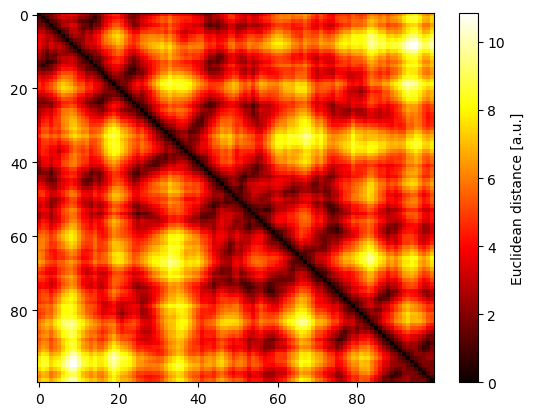

In [18]:
visualize_dmap(dmaps)